## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2022


# Homework 2

- **100 points [7% of your final grade]**
- **Due Sunday, March 6 by 11:59pm** 
- (*no submissions accepted after March 9 by 11:59pm*)

**Goals of this homework:** There are four objectives of this homework: 

* Become familiar with Apache Spark;
* Get hands-on experience using Spark built-in functions like PageRank;
* Work out Hubs and Authorities by hand;
* Try some LSH problems.

*Submission instructions:* You should post your notebook to canvas (look for the homework 2 assignment there). Name your submission **your-uin_hw2.ipynb**, so for example, my submission would be something like **555001234_hw2.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. When you are done, download your notebook from colab and submit it to canvas.

*Collaboration declaration:* If you worked with someone on this homework, please be sure to mention that. Remember to include citations to any sources you use in the homework.

*Write your collaboration/references here*

## Preliminaries: Introduction to the Dataset
We will use a dataset of tweets concerning members of the US congress. The data spans almost a year (from October 3rd, 2018 to September 25th, 2019) covering 576 of the members. Any tweet or retweet posted by the 576 members or directed to them by other Twitter users were collected.

Originally there were more than 200 million tweets collected but we have sampled 400,000 tweets for this homework.

Below is a summary of all datasets used for this homework:

| Dataset                        | Description |
| :---                                                       | :---
| Congress members               | 576 twitter ids and screen names |
| Sample tweets                  |400k sample tweets|
| ~~User hashtags~~                  | ~~all pairs of <user, hashtag>~~|
| User mentions                  | all pairs of <src_user_id, src_dest_id, frequency> |



Following are the steps that you need to execute to install spark. Remember you need to execute them everytime after your runtime is disconnected

In [11]:
!pip install pyspark
!pip install graphframes
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!curl -L -o "/usr/local/lib/python3.7/dist-packages/pyspark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 41.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=9077e5052021b973bfeaadf42d6293962187847a31dff49bafebe44645ec237d
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
     |████████████████████████████████| 154 kB 47.7 MB/s 
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and

The cell below will download the dataset from S3 to us-congress-tweets directory

In [12]:
!mkdir us-congress-tweets
!wget https://us-congress.s3.amazonaws.com/congress_members.csv -O us-congress-tweets/congress_members.csv
!wget https://us-congress.s3.amazonaws.com/tweets-sample-400k.json -O us-congress-tweets/tweets-sample-400k.json
!wget https://us-congress.s3.amazonaws.com/user_hashtags-1m.csv -O us-congress-tweets/user_hashtags-1m.csv
!wget https://us-congress.s3.amazonaws.com/user_mentions.csv -O us-congress-tweets/user_mentions.csv

--2022-03-06 22:27:27--  https://us-congress.s3.amazonaws.com/congress_members.csv
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 3.5.2.102
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|3.5.2.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13835 (14K) [text/csv]
Saving to: ‘us-congress-tweets/congress_members.csv’

us-congress-tweets/ 100%[===================>]  13.51K  --.-KB/s    in 0.002s  

2022-03-06 22:27:27 (6.77 MB/s) - ‘us-congress-tweets/congress_members.csv’ saved [13835/13835]

--2022-03-06 22:27:27--  https://us-congress.s3.amazonaws.com/tweets-sample-400k.json
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 3.5.2.102
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|3.5.2.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202495914 (193M) [application/json]
Saving to: ‘us-congress-tweets/tweets-sample-400k.json’

u

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

In [14]:
# create a Spark session
conf = SparkConf().set("spark.ui.port", "4050")

# create a Spark context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()


In [15]:
# First let's read Twitter ids and screen names of the 576 US congress members

congress_members = spark.read.csv("us-congress-tweets/congress_members.csv", header=True)
congress_members.show()
print("Number of congress members tracked:", congress_members.count())

+------------------+---------------+
|            userid|    screen_name|
+------------------+---------------+
|         776664410|  RepCartwright|
|         240363117|   RepTomMarino|
|837722935095930883| RepScottTaylor|
|        1069124515|     RepLaMalfa|
|818460870573441028|  RepTomGarrett|
|         163570705|     repcleaver|
|          19739126|      GOPLeader|
|          33563161| RepJoseSerrano|
|        2861616083|USRepGaryPalmer|
|        1074518754| SenatorBaldwin|
|         305620929|  Call_Me_Dutch|
|         381152398| RepTerriSewell|
|         834069080| RepDavidRouzer|
|         249787913|  SenatorCarper|
|         188019606|        Clyburn|
|         217543151|SenatorTimScott|
|          39249305| USRepMikeDoyle|
|          33537967|   amyklobuchar|
|         249410485|  SanfordBishop|
|          23124635|    TomColeOK04|
+------------------+---------------+
only showing top 20 rows

Number of congress members tracked: 576


In [16]:
user_mentions = spark.read.csv("us-congress-tweets/user_mentions.csv", header=True)
user_mentions.show()
#print("Number of congress members tracked:", congress_members.count())

+------------------+------------------+-----+
|               src|               dst|count|
+------------------+------------------+-----+
|917194889275699201|        1249982359|    1|
|917570582555779072|         251918778|    1|
|         633674091|         432895323|   48|
|913222391416934402|         432895323|  261|
|         217574712|          47203904|    1|
|931278145679847424|         320757267|    1|
|897332217646522368|          92186819|    8|
|        2308265716|          18061669|    4|
|822826488500088832|        1249982359|  132|
|728645535566008320|958064770019741696|    1|
|827323185058033665|          14247236|   11|
|          36566383|826629809954553856|    2|
|913125313172918272|         432895323|   90|
|860643294367318016|         432895323|   52|
|866790059802079234|         432895323|  148|
|888055635828502530|          16056306|    2|
|        3141820397|         112006107|    1|
|836681162638532608|         262756641|    1|
|         157952243|         10239

We can use `spark.read.json(...)` without schema to load the tweets into a dataframe but this will be slow for two reasons:
* First, it will make one pass over the data to build a schema of the content, then a second pass to read the content and parse it to the dataframe. 
* It will read all the content of the Tweet JSON objects but we only need few fields for a given task.

Thus we define our own schema something like the following:

In [17]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
twitter_date_format="EEE MMM dd HH:mm:ss ZZZZZ yyyy"

user_schema = StructType([
    StructField('created_at', TimestampType(), True),
    StructField('followers_count', LongType(), True),
    StructField('id', LongType(), True),
    StructField('name', StringType(), True),
    StructField('screen_name', StringType(), True)
])

hashtag_schema = ArrayType(StructType([StructField('text', StringType(), True)]))
user_mentions_schema = ArrayType(StructType([StructField('id', LongType(), True),
                                             StructField('screen_name', StringType(), True)]))
entities_schema = StructType([
    StructField('hashtags', hashtag_schema, True),
    StructField('user_mentions', user_mentions_schema, True)
    ])

retweeted_status_schema =StructType([        
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema)
    ])

tweet_schema =StructType([
        StructField("text", StringType(), True),
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema),
        StructField("entities", entities_schema),
        StructField("retweeted_status", retweeted_status_schema)
    ])

Now we are ready to read the tweets with `spark.read.json` passing our own schema as follows:

In [18]:
tweets = spark.read.option("timestampFormat", twitter_date_format)\
                   .json('us-congress-tweets/tweets-sample-400k.json', tweet_schema)\
                   .withColumn('user_id',F.col('user.id'))
tweets.printSchema()

root
 |-- text: string (nullable = true)
 |-- id: long (nullable = true)
 |-- in_reply_to_user_id: long (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: timestamp (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- user_mentions: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- screen_name: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- in_reply_to_user_id: long (nul

In [19]:
tweets.show(10)

+--------------------+-------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+------------------+
|                text|                 id|in_reply_to_user_id|in_reply_to_status_id|         created_at|                user|            entities|    retweeted_status|           user_id|
+--------------------+-------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+------------------+
|RT @maddow: "I he...|1047999818038050816|               null|                 null|2018-10-05 00:00:02|{2017-03-22 03:11...|{[], [{16129920, ...|{1047941326975766...|844386122822119424|
|@ChuckGrassley @S...|1047999818579292160|           10615232|                 null|2018-10-05 00:00:02|{2016-01-29 01:49...|{[], [{10615232, ...|                null|        4828166688|
|RT @cm_merlin: @f...|1048000082237247488|               null|   

## (30 points) Part 1: Let's Fire up Spark for Real

Okay, now that we've finally got our data loaded, we are ready to get our hands dirty with Spark. As you know, Spark comes with lots of built-in functions and nice capabilities. Indeed, you will find that to answer the problems below, there are **many** possible approaches. Please refer to the Stanford Spark tutorial we posted alongside this homework. Also feel free to Google around for some Spark resources, but we list a few here to get you started:

* https://spark.apache.org/docs/latest/sql-ref-functions-builtin.html#aggregate-functions
* https://spark.apache.org/docs/latest/sql-getting-started.html#running-sql-queries-programmatically


### Exploratory Data Analysis

a) How many unique users are there? 

In [20]:
# your code here for unique users
tweets.select(tweets.user.id).distinct().count() #unique users by id who tweeted

198098

In [21]:
tweets.select(tweets.user_id).distinct().count() #unique users by id who tweeted using user_id field

198098

In [22]:
tweets.select(tweets.retweeted_status.user.id).distinct().count() #unique users by retweeted user id, users who retweeted or were retweeted

38166

In [23]:
tweets.filter(tweets.retweeted_status.isNull()).select(F.countDistinct("id")).show() #filter out the tweets with retweeted_status as null and count those ids

+------------------+
|count(DISTINCT id)|
+------------------+
|            102728|
+------------------+



b) How many times is the user **GOPLeader** mentioned?


In [90]:
# code here
from pyspark.sql.functions import sum as _sum

gopleader_id=congress_members.filter(F.col("screen_name").eqNullSafe("GOPLeader")).select("userid").collect()[0]['userid']
gop_mentions_count = tweets.filter(F.array_contains(F.col('entities.user_mentions.id'), int(gopleader_id))).count() 
total_gop_count = tweets.select(F.col("user.screen_name"),
              F.explode(tweets.entities.user_mentions.screen_name).alias("mention")).groupby("mention").agg(F.count('mention').alias("count")).filter(F.col('mention').contains("GOPLeader")).collect()[0]["count"] #.show()
print("Count from unique GOPLeader mentions:", gop_mentions_count)
print("Count from total mentions for GOP_Leader:", total_gop_count)
user_mention_csv_count=user_mentions.filter(F.col('dst').like(gopleader_id)).groupBy(F.col('dst')).agg(_sum("count").alias("sum of mentions")).collect()[0]["sum of mentions"] 
print("Count from user mentions data:", int(user_mention_csv_count))

Count from unique GOPLeader mentions: 4728
Count from total mentions for GOP_Leader: 4761
Count from user mentions data: 52723


c) Now find the top-5 most mentioned members of Congress.

In [42]:
# code here

df_explode_mention_id = tweets.select('*',F.explode(tweets.entities.user_mentions.id).alias("mention_id"))
#df_explode_mention_id.show()
list_uid= [data[0] for data in congress_members.select('userid').collect()]
df_filtered_uid = df_explode_mention_id.where(df_explode_mention_id.mention_id.isin(list_uid))
#df_filtered_uid.show()

In [39]:
df_filtered_uid.groupby('mention_id').count().sort(F.desc("count")).show(5)
tempdf = df_filtered_uid.groupby('mention_id').count().sort(F.desc("count"))
tempdf.join(congress_members, congress_members.userid == tempdf.mention_id, 'inner')\
                                            .sort(F.col('count').desc())\
                                            .select('screen_name', 'count').limit(5).show()

+----------+-----+
|mention_id|count|
+----------+-----+
|  15764644|16135|
|1249982359|15021|
| 432895323|14412|
|  17494010|13738|
|  29501253|13288|
+----------+-----+
only showing top 5 rows

+---------------+-----+
|    screen_name|count|
+---------------+-----+
|    NancyPelosi|16135|
|   senatemajldr|15021|
|LindseyGrahamSC|14412|
|     SenSchumer|13738|
|  RepAdamSchiff|13288|
+---------------+-----+



d) For each month in the dataset, report the top-5 most mentioned users (across all users in the dataset, not just the members of Congress). 

In [81]:
# code here
#First approach based on only month (not considering year basically)

monthly_top5_basedata=tweets.withColumn("month_of_tweet",F.month("created_at"))\
                            .withColumn("user_mention",F.explode(F.col("entities.user_mentions")) )\
                            .select("month_of_tweet", "user_mention.*")\
                            .groupBy("month_of_tweet","id", "screen_name")\
                            .agg(F.count("id").alias("count_of_tweets"))
#monthly_top5_basedata.show(2)

monthly_udf_input=monthly_top5_basedata.withColumn("data_struct", F.struct("id", "screen_name", "count_of_tweets"))\
                                      .groupBy("month_of_tweet").agg(F.collect_list("data_struct").alias("monthly_data"))

def ranking(arr):
    ranked = list(reversed(sorted(arr, key= lambda x: x['count_of_tweets'])))[0:5]
    output = list(map(lambda x: x['screen_name'], ranked))
    return output
  
rank_udf = F.udf(ranking,StringType())
resultant_df_top5 = monthly_udf_input.select(F.col("month_of_tweet"), rank_udf(F.col("monthly_data")).alias("Top 5 Screen Names")).sort("month_of_tweet")
resultant_df_top5.show(truncate=False)

+--------------+-----------------------------------------------------------------------------+
|month_of_tweet|Top 5 Screen Names                                                           |
+--------------+-----------------------------------------------------------------------------+
|1             |[realDonaldTrump, SpeakerPelosi, SenSchumer, senatemajldr, LindseyGrahamSC]  |
|2             |[marcorubio, realDonaldTrump, RepAdamSchiff, SpeakerPelosi, SenSanders]      |
|3             |[RepAdamSchiff, realDonaldTrump, LindseyGrahamSC, marcorubio, SpeakerPelosi] |
|4             |[RepAdamSchiff, realDonaldTrump, SpeakerPelosi, SenSchumer, RepJerryNadler]  |
|5             |[LindseyGrahamSC, realDonaldTrump, SpeakerPelosi, RepAdamSchiff, justinamash]|
|6             |[realDonaldTrump, SenSchumer, senatemajldr, LindseyGrahamSC, SpeakerPelosi]  |
|7             |[realDonaldTrump, RepCummings, senatemajldr, SpeakerPelosi, SenSchumer]      |
|8             |[senatemajldr, realDonaldTrump, Li

In [50]:
#Second approach based on ranking in both month and year

tweets_month_year = tweets.withColumn('created_at_month', F.month(tweets.created_at)).withColumn('created_at_year', F.year(tweets.created_at))
tweets_month_year_exploded = tweets_month_year.select('created_at_month', 'created_at_year', F.explode(tweets.entities.user_mentions.screen_name).alias('user_mentions_screen_name'))
tweets_month_year_exploded_agg = tweets_month_year_exploded.groupby('created_at_month', 'created_at_year', 'user_mentions_screen_name')\
                                                                  .agg({'user_mentions_screen_name': 'count'}).select('*', F.col('count(user_mentions_screen_name)').alias('mention_count'))\
                                                                  .select('user_mentions_screen_name', 'mention_count', F.concat(F.col('created_at_month'), F.lit('-'), F.col('created_at_year')).alias('month_year'))

In [51]:
print('Top 5 most mentioned users of each month is shown in month-year format as follows:')
window_month_year = Window.partitionBy(tweets_month_year_exploded_agg['month_year']).orderBy(tweets_month_year_exploded_agg['mention_count'].desc())
tweets_month_year_exploded_agg_top5 = tweets_month_year_exploded_agg.select('*', F.rank().over(window_month_year).alias('rank_within_month_year'))\
                                      .filter(F.col('rank_within_month_year') <= 5)
tweets_month_year_exploded_agg_top5.show(60)

Top 5 most mentioned users of each month is shown in month-year format as follows:
+-------------------------+-------------+----------+----------------------+
|user_mentions_screen_name|mention_count|month_year|rank_within_month_year|
+-------------------------+-------------+----------+----------------------+
|          realDonaldTrump|         4154|    1-2019|                     1|
|            SpeakerPelosi|         3318|    1-2019|                     2|
|               SenSchumer|         2797|    1-2019|                     3|
|             senatemajldr|         2577|    1-2019|                     4|
|          LindseyGrahamSC|         1818|    1-2019|                     5|
|          realDonaldTrump|         1797|   11-2018|                     1|
|               marcorubio|         1258|   11-2018|                     2|
|              RepSwalwell|         1081|   11-2018|                     3|
|              NancyPelosi|         1035|   11-2018|                     4|
|    

In [76]:
print('Number of months where the top 5 were mentioned in:')
tweets_month_year_exploded_agg_top5.select('user_mentions_screen_name').groupby('user_mentions_screen_name').count().sort(F.col('count').desc()).show(20)
print('Top mentions persisting their ranks in different months:')
tweets_month_year_exploded_agg_top5.groupby('user_mentions_screen_name', 'rank_within_month_year').count().sort(F.col('count').alias('continued_rank_count').desc()).show(20)

Number of months where the top 5 were mentioned in:
+-------------------------+-----+
|user_mentions_screen_name|count|
+-------------------------+-----+
|          realDonaldTrump|   12|
|            SpeakerPelosi|    8|
|          LindseyGrahamSC|    8|
|               SenSchumer|    6|
|             senatemajldr|    6|
|            RepAdamSchiff|    6|
|               marcorubio|    3|
|              NancyPelosi|    2|
|           RepJerryNadler|    1|
|              RepSwalwell|    1|
|               SenSanders|    1|
|           SenatorCollins|    1|
|              justinamash|    1|
|                JeffFlake|    1|
|            lisamurkowski|    1|
|              RepCummings|    1|
|               Jim_Jordan|    1|
+-------------------------+-----+

Top mentions persisting their ranks in different months:
+-------------------------+----------------------+-----+
|user_mentions_screen_name|rank_within_month_year|count|
+-------------------------+----------------------+-----+
|    

e) Do you notice anything interesting in your monthly analysis?

Top 5 mentioned users each month lets us know the entities people reach out to or mention in their tweets. Using the further processing/aggregation and other results we can say:
- From the first approach we can see that realDonaldTrump was leading in 6 months irrespective of year and in top 5 in almost all months
- President of United States during the period 2018 to 2019 is mentioned in all the months followed by Speaker Pelosi and Lindsey Graham.
- realDonaldTrump ranks 1st or 2nd in almost all months which doesn't follow continued ranking that's tried to be shown.

## (25 points) Part 2: PageRank
Now let's find out who are the most important users in the dataset by running PageRank over the mentions network. For this problem, we'll define a user-mentions network using relations in `us-congress-tweets/user_mentions.csv`. That is, each user is a node in the graph. If user A mentions user B, then there should be an edge from A to B.

Hint:
* Take a look at GraphFrames: https://graphframes.github.io/graphframes/docs/_site/user-guide.html


In [55]:
from graphframes import *

In [56]:
# your network construction code here
user_mentions.show()
vertices = user_mentions.select('src').union(user_mentions.select('dst')).dropDuplicates().withColumnRenamed('src', 'id')
edges = user_mentions

+------------------+------------------+-----+
|               src|               dst|count|
+------------------+------------------+-----+
|917194889275699201|        1249982359|    1|
|917570582555779072|         251918778|    1|
|         633674091|         432895323|   48|
|913222391416934402|         432895323|  261|
|         217574712|          47203904|    1|
|931278145679847424|         320757267|    1|
|897332217646522368|          92186819|    8|
|        2308265716|          18061669|    4|
|822826488500088832|        1249982359|  132|
|728645535566008320|958064770019741696|    1|
|827323185058033665|          14247236|   11|
|          36566383|826629809954553856|    2|
|913125313172918272|         432895323|   90|
|860643294367318016|         432895323|   52|
|866790059802079234|         432895323|  148|
|888055635828502530|          16056306|    2|
|        3141820397|         112006107|    1|
|836681162638532608|         262756641|    1|
|         157952243|         10239

In [57]:
#create graphframe/network

g = GraphFrame(vertices, edges)

In [58]:
g.inDegrees.show(5)

+------------------+--------+
|                id|inDegree|
+------------------+--------+
|          92186819|    3733|
|          76184375|     136|
|          84406725|     254|
|836628255222427648|       1|
|           7702542|    1000|
+------------------+--------+
only showing top 5 rows



How many vertices are there in your network? And how many edges?

In [59]:
# your code
print("Number of vertices: ",g.vertices.count())
print("Number of edges: ",g.edges.count())

Number of vertices:  1133350
Number of edges:  2064872


Now you can run PageRank on the constructed network. Feel free to use the implementation provided as part of GraphFrames. Use a reset (or teleportation probability) of 0.15. 

In [60]:
# your PageRank code here (should be pretty short since you're just calling a function)
results = g.pageRank(resetProbability=0.15, maxIter=5)

results.vertices.select("id", "pagerank").show()
results.edges.select("src", "dst", "weight").show()

+-------------------+-------------------+
|                 id|           pagerank|
+-------------------+-------------------+
|1000463993499156481|  0.370078375544821|
|1000785956298018817|  0.370078375544821|
|1001877127115915264|0.49522583964215494|
|1001901894720077824|  0.370078375544821|
|1001918958851710976|  0.370078375544821|
|1002162546978250752|  0.370078375544821|
|1002338860162936832| 1.2670050965419668|
|          100414318|  0.370078375544821|
|1004461220013989888|  0.370078375544821|
|1004865478274244610|0.48186169636776066|
|         1005081223|  0.370078375544821|
|1005181791336984576|  0.370078375544821|
|         1005243704|  0.370078375544821|
|1005412271437369344|  0.370078375544821|
|1005586535436226561|  0.370078375544821|
|1006046436272713728|  0.370078375544821|
|1006268755058577408|  0.370078375544821|
|1006942052104527872|  0.370078375544821|
|1006962721387147264|  0.370078375544821|
|         1007942148|  0.370078375544821|
+-------------------+-------------

In [61]:
results_4iter = g.pageRank(resetProbability=0.15, maxIter=4)

results_4iter.vertices.select("id", "pagerank").show()
results_4iter.edges.select("src", "dst", "weight").show()

+-------------------+-------------------+
|                 id|           pagerank|
+-------------------+-------------------+
|1000463993499156481|0.34116146737305353|
|1000785956298018817|0.34116146737305353|
|1001877127115915264|0.47749641236212276|
|1001901894720077824|0.34116146737305353|
|1001918958851710976|0.34116146737305353|
|1002162546978250752|0.34116146737305353|
|1002338860162936832|  1.431206369967797|
|          100414318|0.34116146737305353|
|1004461220013989888|0.34116146737305353|
|1004865478274244610| 0.4562668855697758|
|         1005081223|0.34116146737305353|
|1005181791336984576|0.34116146737305353|
|         1005243704|0.34116146737305353|
|1005412271437369344|0.34116146737305353|
|1005586535436226561|0.34116146737305353|
|1006046436272713728|0.34116146737305353|
|1006268755058577408|0.34116146737305353|
|1006942052104527872|0.34116146737305353|
|1006962721387147264|0.34116146737305353|
|         1007942148|0.34116146737305353|
+-------------------+-------------

In [62]:
top10_MI5 = results.vertices.select("id", "pagerank").sort(F.col("pagerank").desc()) #.show(10)
top10_MI4 = results_4iter.vertices.select("id", "pagerank").sort(F.col("pagerank").desc()) #.show(10)

#top10_MI4.show(10)
#top10_MI5.show(10)

+------------------+------------------+
|                id|          pagerank|
+------------------+------------------+
|        1249982359| 7568.352824303757|
|          25073877| 7187.506760989088|
|         278145569| 6486.617554042715|
|         240393970|  6007.09310778312|
|          15764644| 5303.102171147152|
|         242426145|4885.1692649574115|
|          15808765| 4761.687265993736|
|822215679726100480| 4676.949201920217|
|          17494010| 4671.003122618746|
|         242555999| 4571.108891587266|
+------------------+------------------+
only showing top 10 rows

+------------------+-----------------+
|                id|         pagerank|
+------------------+-----------------+
|         240393970|7036.967000240482|
|          25073877|6701.685539517161|
|822215679726100480|6284.148813341785|
|        4924463189|5981.435708340409|
|        1249982359|5587.588320042423|
|          15764644|5061.313584770873|
|         242555999|4998.188411171005|
|          15808765|4698

OK, let's see what we found. List the top-10 users based on the PageRank values calculated above.

In [74]:
# Top 10 accounts 
print("Users set 1:")
top10_MI4.show(10)
print("Users set 2:")
top10_MI5.show(10)

Users set 1:
+------------------+------------------+
|                id|          pagerank|
+------------------+------------------+
|        1249982359| 7568.352824303757|
|          25073877| 7187.506760989088|
|         278145569| 6486.617554042715|
|         240393970|  6007.09310778312|
|          15764644| 5303.102171147152|
|         242426145|4885.1692649574115|
|          15808765| 4761.687265993736|
|822215679726100480| 4676.949201920217|
|          17494010| 4671.003122618746|
|         242555999| 4571.108891587266|
+------------------+------------------+
only showing top 10 rows

Users set 2:
+------------------+-----------------+
|                id|         pagerank|
+------------------+-----------------+
|         240393970|7036.967000240482|
|          25073877|6701.685539517161|
|822215679726100480|6284.148813341785|
|        4924463189|5981.435708340409|
|        1249982359|5587.588320042423|
|          15764644|5061.313584770873|
|         242555999|4998.188411171005

What do you observe? are the top 10 users congress members? are there outsiders?

Hint: You can use https://twitter.com/intent/user?user_id=? to find out more info about the users

Not all top users are congress members with presence of some outsiders/outisde groups which can be seen and using hint link to analyse more currently about users:

- 3rd user - President Trump 45 Archived - The President is not a part of the congress but plays a major role hence its listing is understood.
- 4th user - CelebrateMemphs - It's an international festival and not much idea on why its being mentioned that frequently (or many places)
- 2nd user - 25073877 - 404 user not found - The user has possibly deleted their twitter handle and is not accessible now.

## (5 points) Bonus Question (Optional)
Until now you have explored different aspects of Spark to investigate tweets by the US Congress. For this (optional) bonus problem, please conduct your own investigation of the data. You can use any combinations of the data files to carry out your investigation. You may use any libraries in Spark that you like, but you must use Spark. Tell us what question motivates you, what you did, what you discovered, and why it is interesting. This is completely open-ended, but we are looking for compelling questions and insights. Good luck!



Feel free to add any number of code/text cells here for your answer!


In [67]:
# top hashtags in the tweets since that give us insight into the trending topics and may help in marketing strategies, 
# stock market fluctutations(Ex: Elon Musk antics), political inclinations and other domains 

tweets.select(F.explode(tweets.entities.hashtags.text).alias("hashtag"))\
      .groupby("hashtag").count().sort(F.desc("count"))\
      .show()

+-------------+-----+
|      hashtag|count|
+-------------+-----+
|    Venezuela| 1224|
|  MoscowMitch| 1123|
|TrumpShutdown|  705|
|         MAGA|  535|
|MuellerReport|  396|
|  NancyPelosi|  349|
| MaduroRegime|  347|
|        Trump|  338|
| BuildTheWall|  333|
| GreenNewDeal|  297|
|    Kavanaugh|  292|
|     BREAKING|  277|
| ForThePeople|  224|
|       Maduro|  224|
|    Democrats|  194|
| DoWhatWeSaid|  179|
|      Mueller|  174|
|         SOTU|  173|
|          GOP|  171|
|          HR1|  168|
+-------------+-----+
only showing top 20 rows



## (20 points) Hubs and Authorities by Hand

Consider the following graph (in adjacency list format):

* A: B, D (that is, A links to B and to D)
* B: D, E
* C: D, E
* D: F, G
* E: C, D, G, H
* F: 
* G: 
* H: C, G

Find the hub and authority score for each node. Please normalize your final scores so they sum to 1.

https://drive.google.com/drive/folders/1jQmigV5OdoNYem0wPaY5_SlL5lh7XEKm?usp=sharing

## (25 points) LSH Problems from the Book

From MMDS [Chapter 3](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf), do the following problems:

* Exercise 3.1.2 (Page 78)
* Exercise 3.2.2 (Page 81)
* Exercise 3.3.3 (Page 90)
* Exercise 3.4.1 (Page 96)
* Exercise 3.4.2 (Page 96)

Please add cells below with your answers (explanation and detail of calculation are required). 


#Question 3.1.2
https://drive.google.com/drive/folders/1d2-7Vpa7KfT9kTaLqHf97OToMbSzVoHk?usp=sharing

#Question 3.2.2
https://drive.google.com/drive/folders/1KbHunYyDKQ7ipSPB6t-mJFF9_fafTeep?usp=sharing

#Question 3.3.3
https://drive.google.com/drive/folders/1zM7XMW1Mf21iyw9k5IuaHyqIdJg40Ubt?usp=sharing

r = 3, b = 10
0.1 -> 0.009955119790251765 | 0.2 -> 0.07718058804273675 | 0.3 -> 0.23944889319887064 | 0.4 -> 0.4838707317677322 | 0.5 -> 0.7369244238361716 | 0.6 -> 0.9122674753991765 | 0.7 -> 0.985015105295655 | 0.8 -> 0.9992340538808936 | 0.9 -> 0.9999978635491371 | 

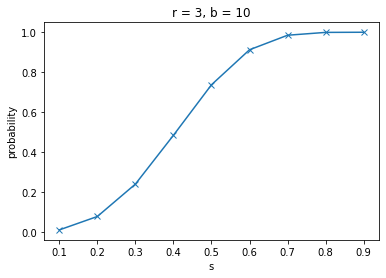

r = 6, b = 20
0.1 -> 1.9999810001669616e-05 | 0.2 -> 0.001279222058761964 | 0.3 -> 0.014479466504172311 | 0.4 -> 0.07880932311056232 | 0.5 -> 0.27018714400947597 | 0.6 -> 0.6154146360312677 | 0.7 -> 0.9181859965846741 | 0.8 -> 0.9977121251546806 | 0.9 -> 0.9999997398129465 | 

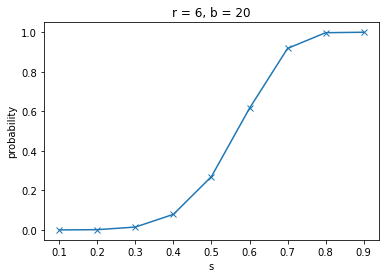

r = 5, b = 50
0.1 -> 0.0004998775195954597 | 0.2 -> 0.01587519984502117 | 0.3 -> 0.11453988231042189 | 0.4 -> 0.4022839522088044 | 0.5 -> 0.7955506304323648 | 0.6 -> 0.9825338277068608 | 0.7 -> 0.9998989958361557 | 0.8 -> 0.9999999976077777 | 0.9 -> 1.0 | 

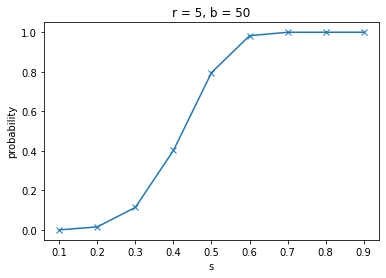

In [64]:
#Question 3.4.1

import numpy as np
import matplotlib.pyplot as plt

s = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def calculate_sCurveVals(b,r):
  for si in s:
    sCurveVal = 1 - pow((1 - pow(si,r)),b)
    sCurveVals.append(sCurveVal)
  return sCurveVals

def print_SCurveVals(slen, sCurveVals):
  for i in range(slen):
    print(s[i], '->',sCurveVals[i], end=' | ')


# For r = 3, b = 10
r = 3
b = 10
sCurveVals = []

print('r = 3, b = 10')
sCurveVals = calculate_sCurveVals(10,3)
print_SCurveVals(len(s), sCurveVals)

plt.plot(np.array(s), np.array(sCurveVals), marker='x')
plt.xlabel('s')
plt.ylabel('probability')
plt.title('r = 3, b = 10')
plt.show()

# For r = 6, b = 20
r = 6
b = 20
sCurveVals = []

print('r = 6, b = 20')
sCurveVals = calculate_sCurveVals(20,6)
print_SCurveVals(len(s), sCurveVals)

plt.plot(np.array(s), np.array(sCurveVals), marker='x')
plt.xlabel('s')
plt.ylabel('probability')
plt.title('r = 6, b = 20')
plt.show()

# For r = 5, b = 50
r = 5
b = 50
sCurveVals = []

print('r = 5, b = 50')
sCurveVals = calculate_sCurveVals(50,5)
print_SCurveVals(len(s), sCurveVals)

plt.plot(np.array(s), np.array(sCurveVals), marker='x')
plt.xlabel('s')
plt.ylabel('probability')
plt.title('r = 5, b = 50')
plt.show()


#Question 3.4.2

https://drive.google.com/drive/folders/1mQqFCuOiFviiGlskoJIZcqXrqFGNAWZG?usp=sharing
